In [91]:
#Importing sys so we can importy Optics.py
import sys
sys.path.insert(0, '~/Initial-Allignment-Assistant-Tool')
#Importing all the definitions form Optics.py
from Optics import *

import Parameters

#Imports numpy
import numpy as np
#Imports improtant functions for juptyer display
from IPython.core.display import display, HTML, Markdown, clear_output
#Improts matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
#Improts widgets for buttons and text boxes for jupyter display
import ipywidgets as widgets
#Imports parser for ini files
import configparser
#Import os to see files and directories
import os
#Colormaps
import matplotlib.cm as cm

system = 'Example01 - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 50

#PRC
#ranges = [[[-5e-3,5e-3],[-5e-3,5e-3]], [[-5e-3,5e-3],[-5e-3,5e-3]], [[-1,2.3],[-1.5,1.5]]]

#Example01
ranges = [[[-.3,.3],[-.3,.3]], [[-.1,.1],[-.1,.1]], [[-np.pi/2,np.pi/2],[-np.pi/2,np.pi/2]]]

ptsElem = []

for analyzeElementIndex in range(len(elements)):

    pts = []
    
    elemsTemp = []

    for element in elements:
        elemsTemp += [element.copy()]
    ran = ranges[analyzeElementIndex]
    for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
        for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
            elemsTemp[analyzeElementIndex] = elements[analyzeElementIndex].copy()
            elemsTemp[analyzeElementIndex].yaw =  elements[analyzeElementIndex].yaw + yaw
            elemsTemp[analyzeElementIndex].pitch =  elements[analyzeElementIndex].pitch + pitch

            flags = beam.calculateFlags(elemsTemp)
            if len(flags) == 0:
                pts += [[yaw, pitch, 'Clear']]
            else:
                label = ""
                for i in range(len(elemsTemp)):
                    for flag in flags:
                        if elemsTemp[i].ID in flag:
                            if 'clipping' in flag:
                                if label != "":
                                    label += ' + '
                                label += 'Clipping ' + elemsTemp[i].ID
                            else:
                                if label != "":
                                    label += ' + '
                                label += 'Missing ' + elemsTemp[i].ID
                pts += [[yaw, pitch, label]]
    ptsElem += [pts]

/home/andre.guimaraes/.conda/envs/IAAT-Env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/andre.guimaraes/.conda/envs/IAAT-Env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


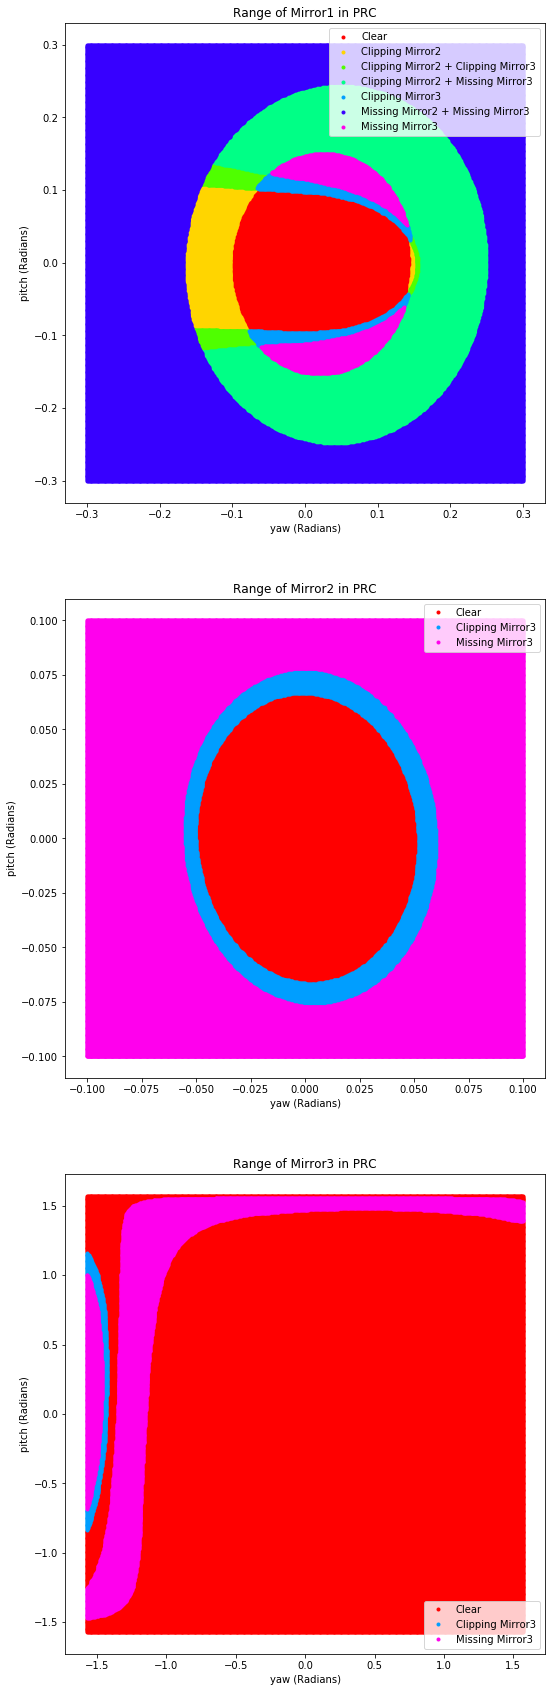

In [88]:
fig, ax = plt.subplots(len(elements), 1, figsize = [10,30])

possibleFlags = []

for pts in ptsElem:
    for pt in pts:
        possibleFlags += [pt[2]]
    
possibleFlags = np.unique(possibleFlags)

possibleColors = [cm.hsv(n/len(possibleFlags)) for n in range(len(possibleFlags))]

for i in range(len(ptsElem)):
    groups = [[] for i in possibleFlags]
    for pt in ptsElem[i]:
        arg = np.argwhere(possibleFlags == [pt[2]])[0][0]
        groups[arg] += [pt + [possibleColors[arg]]]

    for group in groups:
        if len(group) != 0:
            x = [pt[0] for pt in group]
            y = [pt[1] for pt in group]
            label = group[0][2]
            color = group[0][3]
            ax[i].plot(x,y,'.', color = color, label = label)

    ax[i].set_aspect(1)
    ax[i].legend()
    ax[i].set_title("Range of " + elemsTemp[i].ID + " in PRC")
    ax[i].set_xlabel('yaw (Radians)')
    ax[i].set_ylabel('pitch (Radians)')


In [89]:
fig.savefig("Example01 Limit Plots.png")

/home/andre.guimaraes/.conda/envs/IAAT-Env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  """Entry point for launching an IPython kernel.
